In [17]:
import pandas as pd
import numpy as np
import seaborn as sb
import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from get_decision_variable_map import get_decision_variable_map
from get_case_outputs_all_models import get_case_outputs_all_models

In [18]:
import os

current_dir = os.getcwd()
print(current_dir)

c:\Users\ks885\Documents\aa_research\Modeling\spcm_genx_experiment\figures


In [19]:
plots_path = os.path.join(current_dir, 'plots') + "/"
pdf_path = os.path.join(current_dir, 'pdf_tables') + "/"
latex_path = os.path.join(current_dir, 'latex') + "/"
csv_path = os.path.join(current_dir, 'csv') + "/"
jpg_path = os.path.join(current_dir, 'jpg') + "/"


In [20]:
pdc_path = os.path.join(jpg_path, 'pdc') + "/"
if not os.path.exists(pdc_path):
    os.makedirs(pdc_path)
    print("Directory '%s' created" % pdc_path)

In [21]:
# modeling scaling ModelScalingFactor
ModelScalingFactor = 1000

cem_path = os.path.join(os.path.dirname(current_dir), 'GenX.jl', 'research_systems')
policies_path = os.path.join(os.path.dirname(current_dir), 'SPCM', 'research_systems')

date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [22]:
case_names = [    
              "Thermal_Base",
              "2_Hr_BESS", 
              "2_Hr_BESS_Fuelx2",
              "4_Hr_BESS",
              "4_Hr_BESS_Fuelx2",
              "4_Hr_BESS_Fuelx3",
              "4_Hr_BESS_Fuelx4",
              "6_Hr_BESS",
              "6_Hr_BESS_Fuelx2",
              "8_Hr_BESS",
              "8_Hr_BESS_Fuelx2",
              "10_Hr_BESS",
              "10_Hr_BESS_Fuelx2",
              ]

model_types = [
                'cem',
                'pf',
                'dlac-p',
                'dlac-i',
                'slac',
]

# Create a DataFrame with decision_variable_names as the index
decision_variable_map = get_decision_variable_map()

In [23]:
decision_variable_name = 'energy prices'
model_types_list = ['pf', 'dlac-p', 'dlac-i', 'slac']
# model_types_list = ['pf','dlac-p']
string_of_model_types = "_".join(model_types_list)

In [24]:
case_name = case_names[0]

In [25]:
cem_prices, policies_prices_dict, columns_2_print = get_case_outputs_all_models(cem_path, 
                                policies_path, case_name, decision_variable_name, model_types_list)

In [26]:
cem_prices["1"]

0       35.224140
1       35.224140
2       35.224140
3       35.224140
4       35.224140
          ...    
8681    68.806217
8682    35.224140
8683    35.224140
8684    26.981421
8685     0.100000
Name: 1, Length: 8686, dtype: float64

In [27]:
policies_prices_dict['pf']["1"]

0        35.224140
1        35.224140
2        35.224140
3        35.224140
4        35.224140
           ...    
8681    102.402857
8682     35.224140
8683     35.224140
8684     35.224140
8685     35.224140
Name: 1, Length: 8686, dtype: float64

In [28]:
def get_price_duration_curve(price_dur_df, price_data, model_type):
    """
    add a column to given dataframe with the price duration curve for given model
    """
    # take price data and create a copy
    price_df_copy = price_data.copy()
    # create a new column for interval 
    price_df_copy['interval'] = 1
    # sort prices in descending order
    price_df_copy  = price_df_copy.sort_values(by=['1'], ascending=False)
    # reset index
    price_df_copy = price_df_copy.reset_index(drop=True)
    # create a new column for the price duration curve
    price_df_copy['duration'] = price_df_copy['interval'].cumsum()
    # calculate percentage
    price_df_copy['percentage'] = price_df_copy ['duration'] / price_df_copy ['1'].sum()

    # add 'duration' column to price_dur_df as model_type
    price_dur_df[model_type] = price_df_copy['1']

    # return the updated price_dur_df
    return price_dur_df






In [29]:
pdc_all_models = pd.DataFrame()
pdc_all_models = get_price_duration_curve(pdc_all_models, cem_prices, 'cem')
pdc_all_models = get_price_duration_curve(pdc_all_models, policies_prices_dict['pf'], 'pf')
pdc_all_models = get_price_duration_curve(pdc_all_models, policies_prices_dict['dlac-p'], 'dlac-p')
pdc_all_models = get_price_duration_curve(pdc_all_models, policies_prices_dict['dlac-i'], 'dlac-i')
pdc_all_models = get_price_duration_curve(pdc_all_models, policies_prices_dict['slac'], 'slac')

In [30]:
pdc_all_models

,cem,pf,dlac-p,dlac-i,slac
0,5000.0,5000.0,5000.0,5000.0,5000.0
1,5000.0,5000.0,5000.0,5000.0,5000.0
2,5000.0,5000.0,5000.0,5000.0,5000.0
3,5000.0,5000.0,5000.0,5000.0,5000.0
4,5000.0,5000.0,5000.0,5000.0,5000.0
...,...,...,...,...,...
8681,0.1,0.1,0.1,0.1,0.1
8682,0.1,0.1,0.1,0.1,0.1
8683,0.1,0.1,0.1,0.1,0.1
8684,0.1,0.1,0.1,0.1,0.1


In [31]:
def plot_price_duration_curve(pdc_path, case_name, string_of_model_types, 
                              pdc_all_models, font_size=15, overlapping=0.6, lwdth=3):
    """
    Plots the price duration curve for all models.

    Parameters:
    - pdc_all_models: DataFrame containing price duration data for all models.
    - font_size: Font size for the plot labels and titles.
    - overlapping: Transparency level for overlapping lines.
    - lwdth: Line width for the plots.
    """
    sb.set_theme(rc={"figure.figsize": (10, 7), "figure.autolayout": True, 
                     "axes.labelsize": font_size, "xtick.labelsize": font_size, 
                     "ytick.labelsize": font_size, "legend.fontsize": font_size})

    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]})

    # Plot data on both axes
    for model in pdc_all_models.columns:
        sb.lineplot(data=pdc_all_models[model], ax=ax_top, label=model.upper(), 
                    estimator=None, linewidth=lwdth, alpha=overlapping)
        sb.lineplot(data=pdc_all_models[model], ax=ax_bottom, label=model.upper(), 
                    estimator=None, linewidth=lwdth, alpha=overlapping)

    # Set titles and labels
    print_case_name = case_name.replace("_", " ")
    ax_top.set_title(f'Price Duration Curve for {print_case_name}', fontsize=font_size)
    ax_top.set_xlabel('')
    ax_top.set_ylabel('Price ($/MWh)', fontsize=font_size)
    ax_bottom.set_ylabel('Price ($/MWh)', fontsize=font_size)
    ax_bottom.set_xlabel("Frequency (hrs)", fontsize=font_size)

    # Adjust y-axis limits and ticks
    ax_top.set_ylim(100, 5050)
    ax_top.set_yticks(np.arange(500, 5050, 500))
    ax_bottom.set_ylim(-10, 100)
    ax_bottom.set_yticks(np.arange(0, 101, 25))

    # Remove unwanted labels
    ax_top.set_yticklabels(np.arange(500, 5050, 500), size=font_size)
    ax_bottom.set_yticklabels(np.arange(0, 101, 25), size=font_size)

    # Hide spines between the two plots
    ax_top.spines['bottom'].set_visible(False)
    ax_bottom.spines['top'].set_visible(False)

    # Add diagonal lines to indicate the break
    d = .015
    kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
    ax_top.plot((-d, +d), (-d, +d), **kwargs)
    ax_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)

    kwargs.update(transform=ax_bottom.transAxes)
    ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax_bottom.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    ax_top.set_xticklabels([])  # Remove x-tick labels on the top plot

    # Remove the legend from the bottom plot
    ax_bottom.legend_.remove()
    # plt.show()
    # save to jpg file in pdc_path
    plt.savefig(os.path.join(pdc_path, f"pdc_{case_name}_{string_of_model_types}.jpg"), dpi=300, bbox_inches='tight')


Case Name: Thermal_Base

Case Name: 2_Hr_BESS

Case Name: 2_Hr_BESS_Fuelx2

Case Name: 4_Hr_BESS

Case Name: 4_Hr_BESS_Fuelx2

Case Name: 4_Hr_BESS_Fuelx3

Case Name: 4_Hr_BESS_Fuelx4

Case Name: 6_Hr_BESS

Case Name: 6_Hr_BESS_Fuelx2

Case Name: 8_Hr_BESS

Case Name: 8_Hr_BESS_Fuelx2

Case Name: 10_Hr_BESS

Case Name: 10_Hr_BESS_Fuelx2



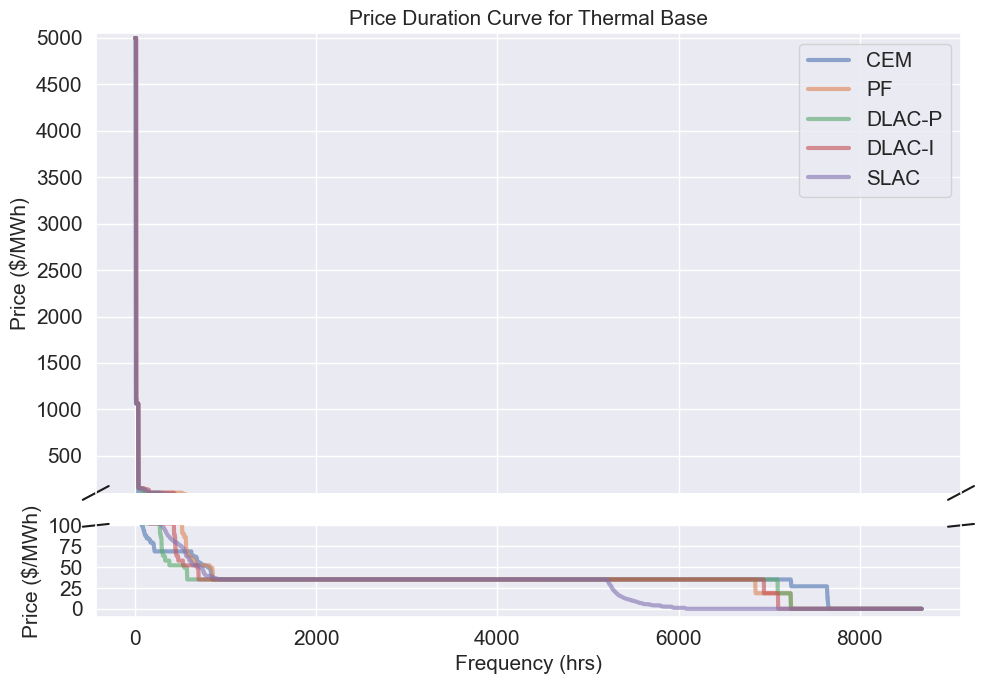

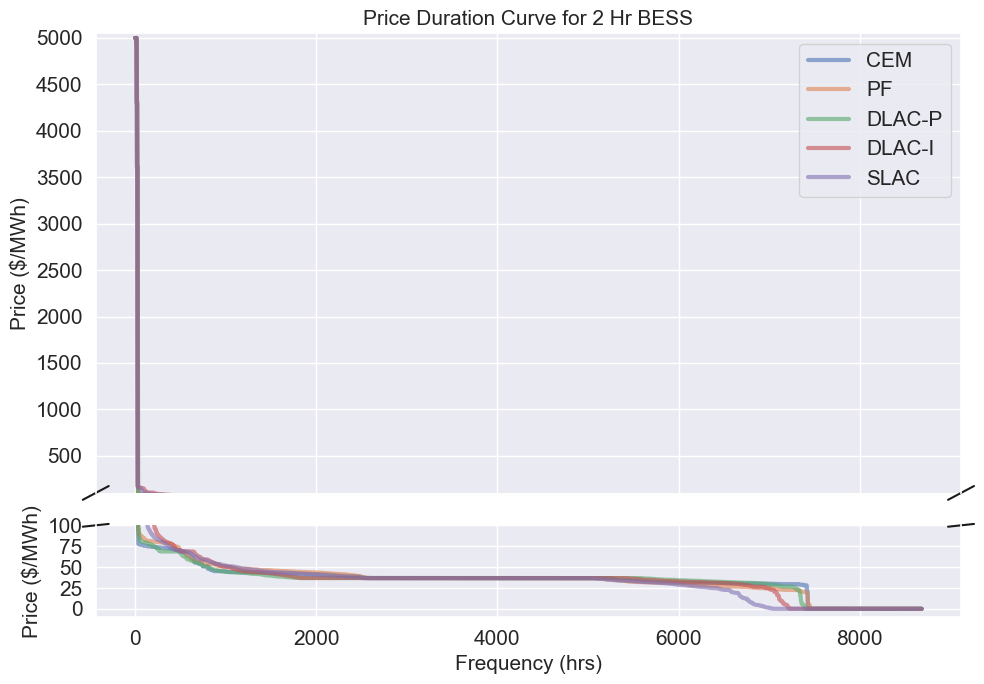

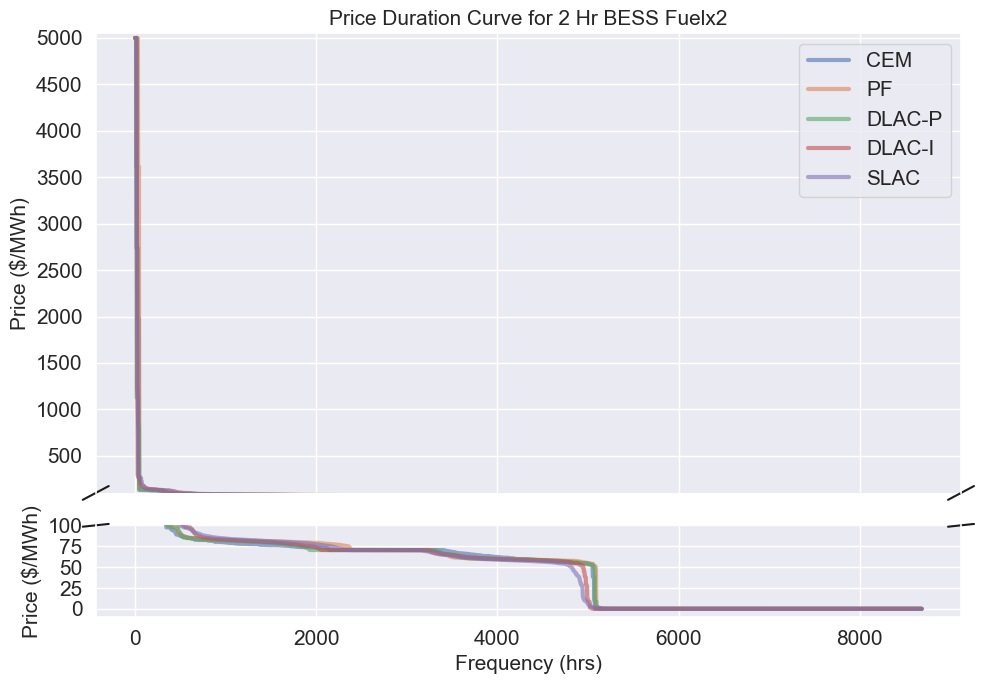

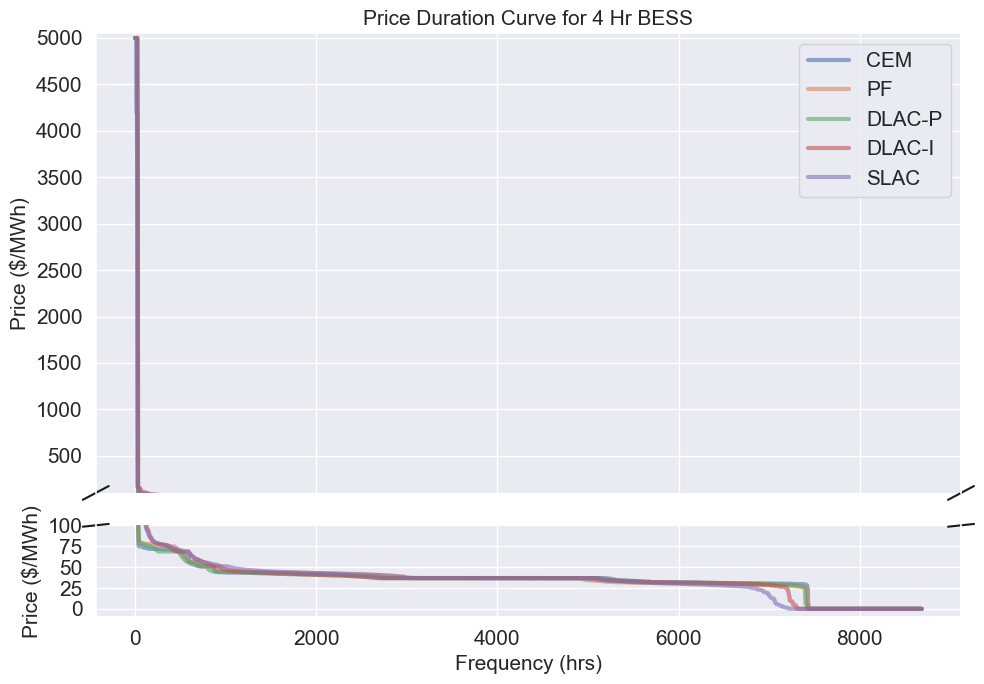

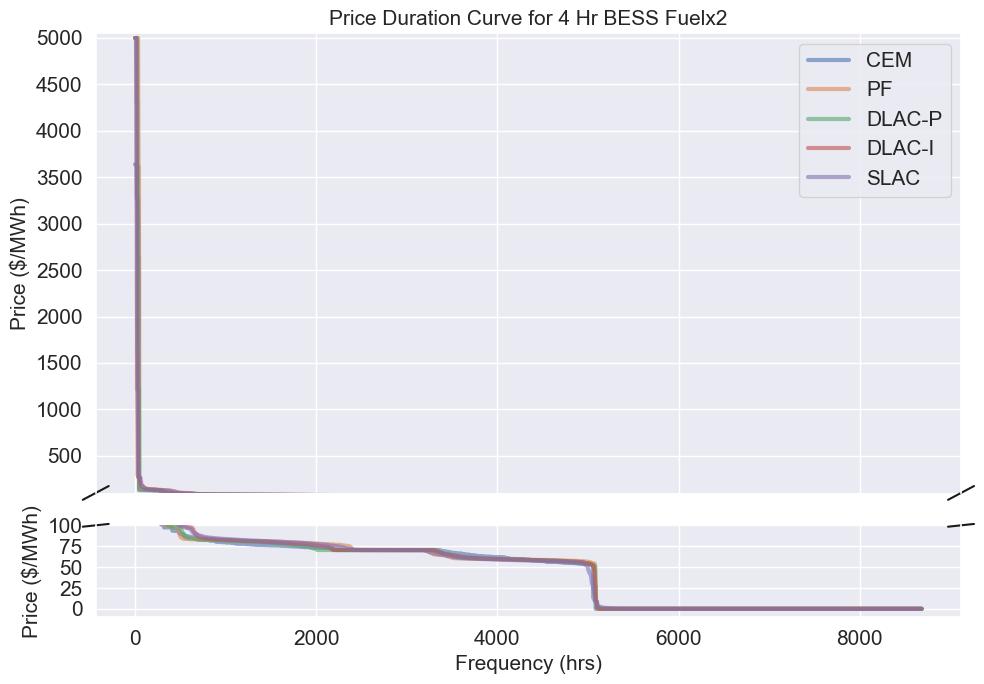

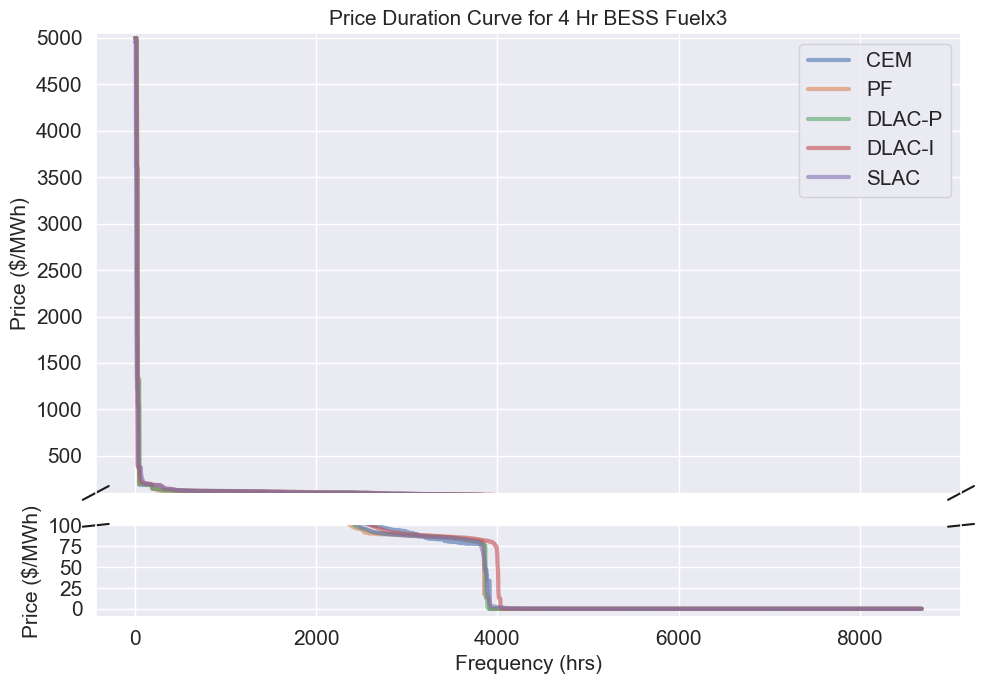

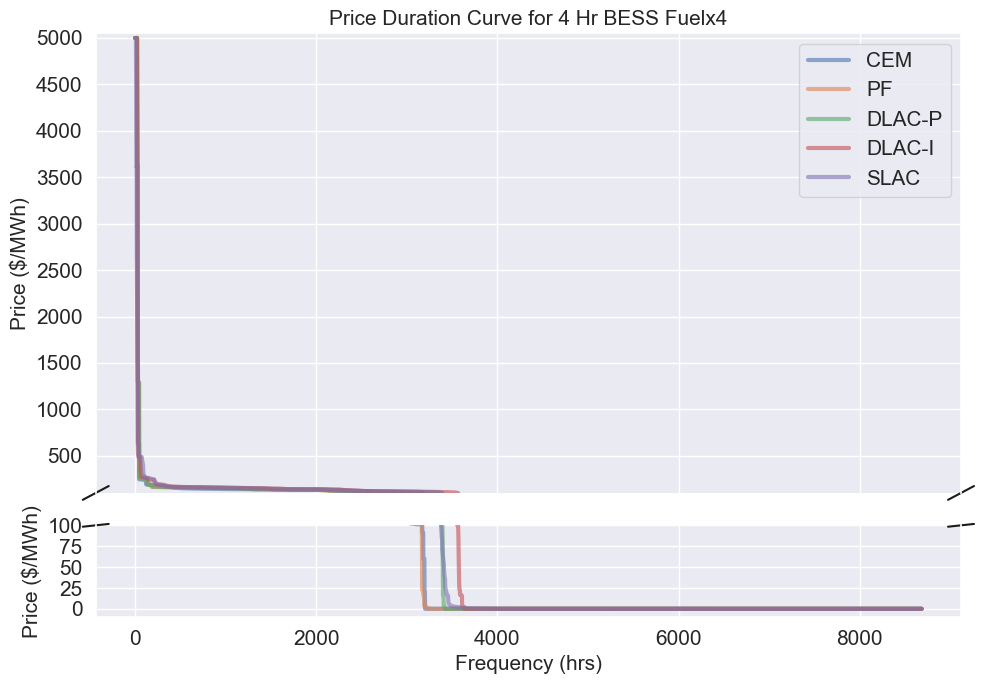

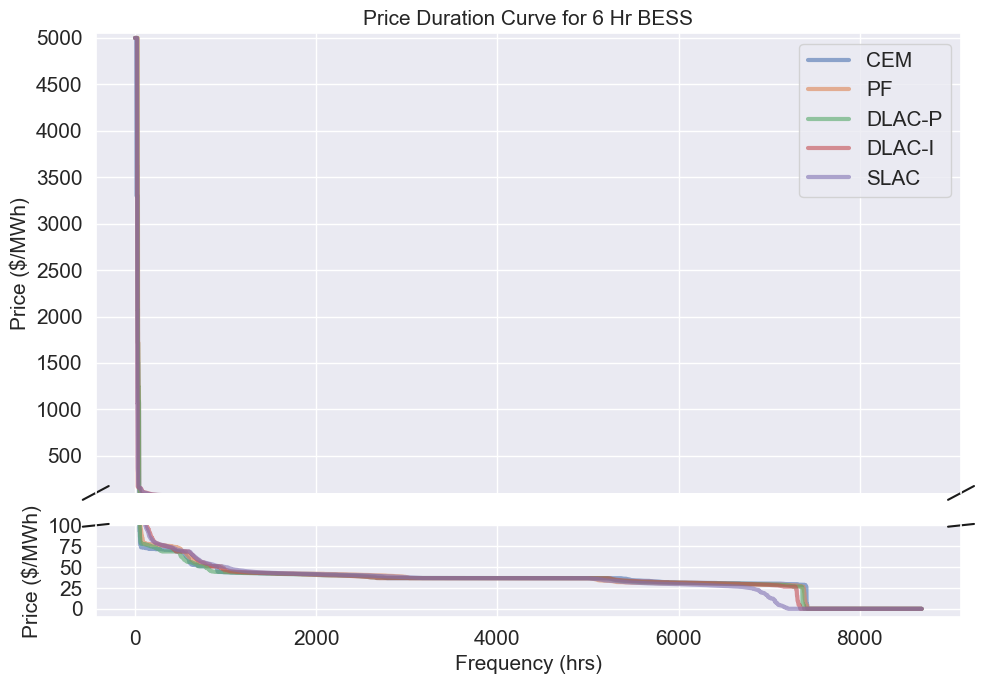

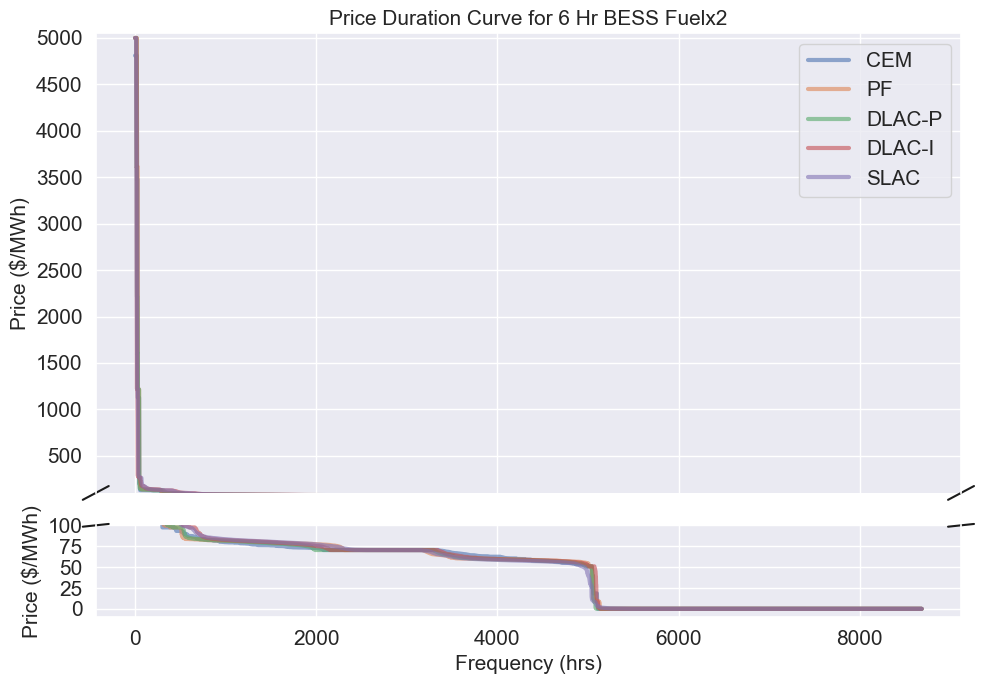

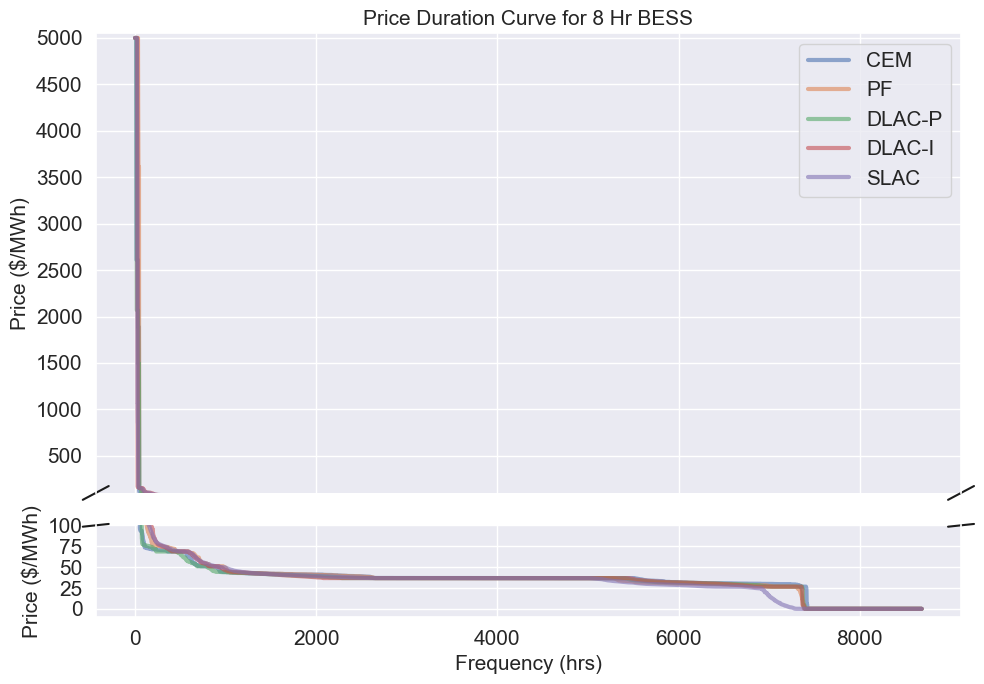

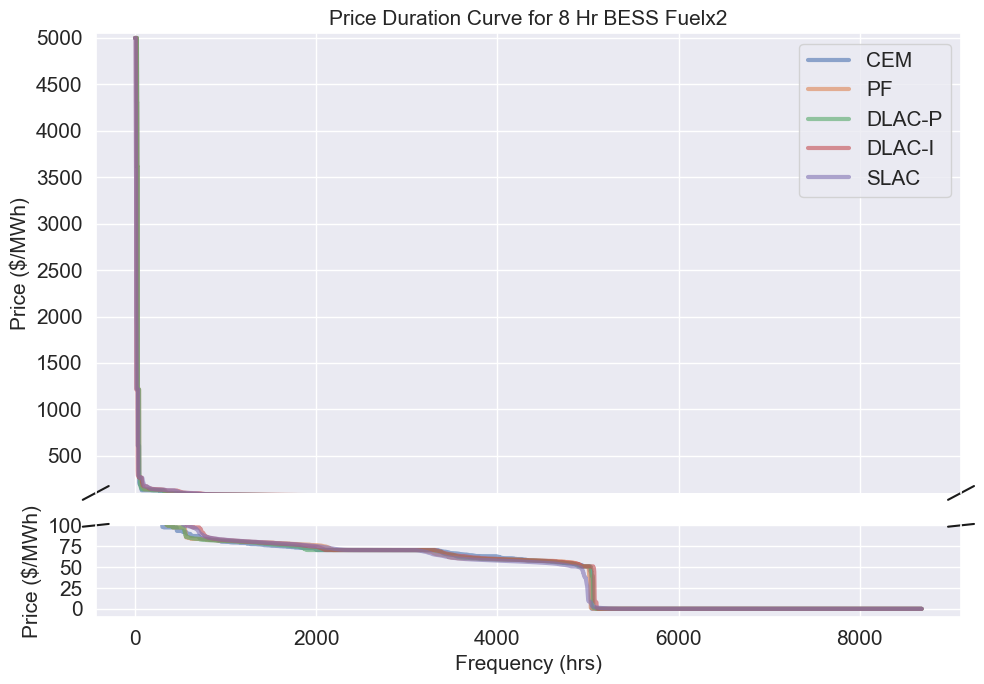

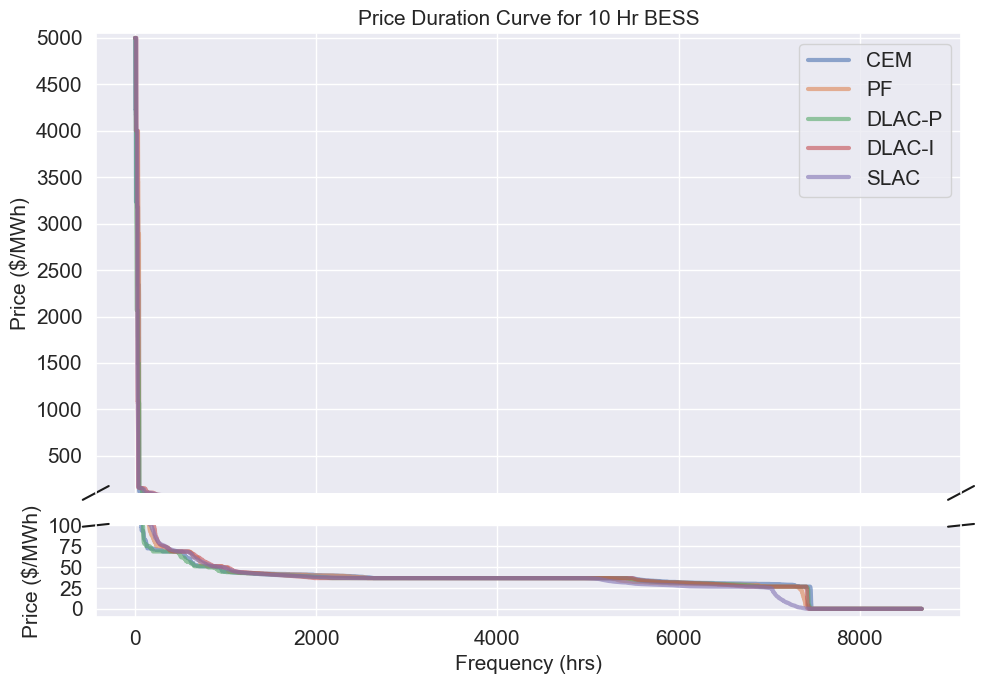

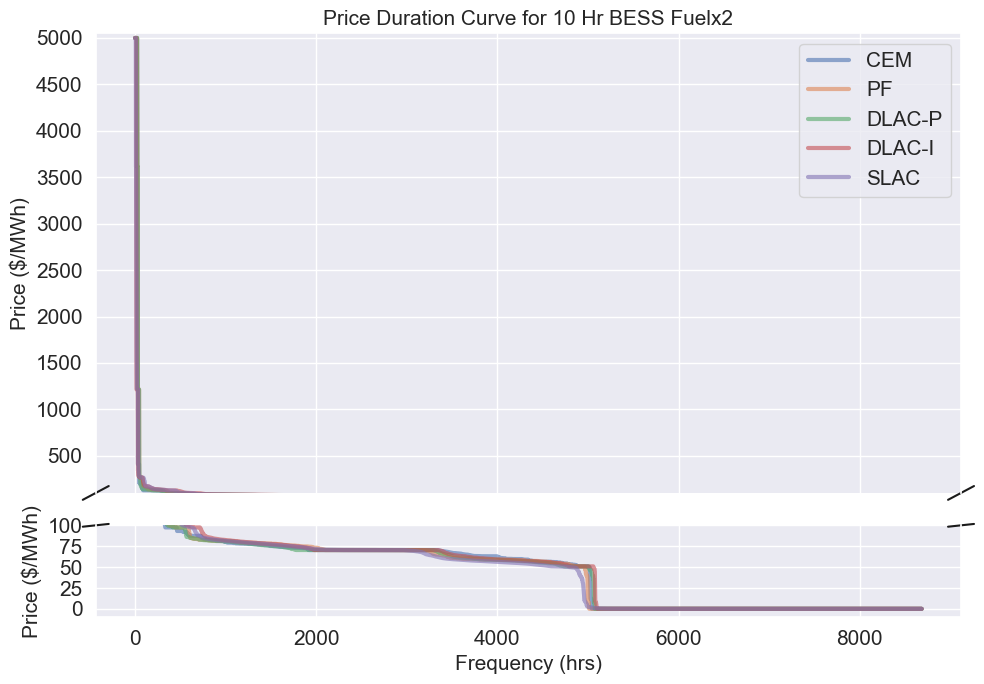

In [32]:
for case_name in case_names:

    print('Case Name: ' + case_name + '\n')

    cem_prices, policies_prices_dict, columns_2_print = get_case_outputs_all_models(cem_path, 
        policies_path, case_name, decision_variable_name, model_types_list)
    
    pdc_all_models = pd.DataFrame()
    pdc_all_models = get_price_duration_curve(pdc_all_models, cem_prices, 'cem')
    pdc_all_models = get_price_duration_curve(pdc_all_models, policies_prices_dict['pf'], 'pf')
    pdc_all_models = get_price_duration_curve(pdc_all_models, policies_prices_dict['dlac-p'], 'dlac-p')
    pdc_all_models = get_price_duration_curve(pdc_all_models, policies_prices_dict['dlac-i'], 'dlac-i')
    pdc_all_models = get_price_duration_curve(pdc_all_models, policies_prices_dict['slac'], 'slac')

    # plot price duration curve
    plot_price_duration_curve(pdc_path, case_name, 
                              string_of_model_types, pdc_all_models, 
                              font_size=15, overlapping=0.6, lwdth=3)
    
    



